In [62]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

np.random.seed(42)

In [63]:
# Carico il dataset con le features
df = pd.read_csv('features.csv')

# Inserisco in ciascuna riga del dataframe delle features i pesi ottimi (scaricati nel file get_portfolio_weights.ipynb) della settimana successiva (che saranno la variabile da predire)
next_week_optimal_weights= pd.read_csv("df_optimal_weights.csv")
next_week_optimal_weights = next_week_optimal_weights.rename(columns=lambda x: "next_week_opt_weight_" + x)
next_week_optimal_weights= next_week_optimal_weights[1:].copy()
next_week_optimal_weights.loc[len(next_week_optimal_weights)+1] = [np.nan] * next_week_optimal_weights.shape[1]
next_week_optimal_weights.index = pd.RangeIndex(start=0, stop=len(next_week_optimal_weights), step=1)
df= pd.concat([df, next_week_optimal_weights], axis=1)
df = df.dropna()

In [64]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

# Supponiamo che il dataframe df sia già caricato e contenga i dati necessari

# Definizione delle variabili
window_size = 4

# Separazione delle colonne di input e delle colonne dei pesi
data_inputs = df.iloc[:, :-5]
data_weights = df.iloc[:, -5:]

# Normalizzazione dei dati di input
scaler = MinMaxScaler()
data_inputs_scaled = scaler.fit_transform(data_inputs)
data_combined_scaled = np.concatenate((data_inputs_scaled, data_weights.values), axis=1)

# Funzione per creare sequenze temporali
def create_sequences(data, window_size):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size, :-5])
        y.append(data[i + window_size - 1, -5:])
    return np.array(X), np.array(y)

# Creazione delle sequenze
X, y = create_sequences(data_combined_scaled, window_size)

# Divisione dei dati in train e test set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.698, shuffle=False)

lstm_units= [50, 100, 150, 200]
activation_functions= ["tanh", "sigmoid", "relu"]
epochs= [50, 100, 150]
best_parameters= {"lstm_units": 0, "activation_functions": "", "epochs": 0}
best_mse= 0
best_y_pred= []

for units in lstm_units:
    for activation_function in activation_functions:
        for n in epochs:

            # Costruzione del modello LSTM
            model = Sequential()
            model.add(LSTM(units, activation=activation_function, input_shape=(window_size, X_train.shape[2])))
            model.add(Dense(5, activation='softmax'))  # softmax garantisce che la somma dei pesi sia 1 e che siano non negativi

            model.compile(optimizer='adam', loss='mean_squared_error')

            # Addestramento del modello
            early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
            history = model.fit(X_train, y_train, epochs=n, validation_data=(X_test, y_test), callbacks=[early_stopping])

            # Previsione sui dati di test
            y_pred = model.predict(X_test)

            # Calcolo del Mean Squared Error (MSE)
            mse = mean_squared_error(y_test, y_pred)

            if best_mse == 0:
                best_mse= mse
                best_parameters["lstm_units"]= units
                best_parameters["activation_functions"]= activation_function
                best_parameters["epochs"]= n
                best_y_pred= y_pred
            elif mse < best_mse:
                best_mse= mse
                best_parameters["lstm_units"]= units
                best_parameters["activation_functions"]= activation_function
                best_parameters["epochs"]= n
                best_y_pred= y_pred


print(f"Best parameters: {best_parameters}")
print(f"Best mse: {best_mse}")


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0310 - val_loss: 0.0327
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0304 - val_loss: 0.0327
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0303 - val_loss: 0.0316
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0303 - val_loss: 0.0318
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0299 - val_loss: 0.0327
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0295 - val_loss: 0.0316
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0295 - val_loss: 0.0314
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0296 - val_loss: 0.0318
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0294 - val_loss: 0.0321
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0295 - val_loss: 0.0316
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0293 - val_loss: 0.0318
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0296 - v

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0309 - val_loss: 0.0322
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0301 - val_loss: 0.0323
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0297 - val_loss: 0.0330
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0301 - val_loss: 0.0317
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0294 - val_loss: 0.0330
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0299 - val_loss: 0.0325
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0298 - val_loss: 0.0322
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0293 - val_loss: 0.0325
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0298 - val_loss: 0.0325
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0295 - val_loss: 0.0329
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0295 - val_loss: 0.0324
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0294 - val_

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0310 - val_loss: 0.0320
Epoch 2/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0302 - val_loss: 0.0319
Epoch 3/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0302 - val_loss: 0.0316
Epoch 4/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0299 - val_loss: 0.0315
Epoch 5/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0301 - val_loss: 0.0315
Epoch 6/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0293 - val_loss: 0.0315
Epoch 7/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0301 - val_loss: 0.0311
Epoch 8/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0296 - val_loss: 0.0314
Epoch 9/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0294 - val_loss: 0.0317
Epoch 10/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0300 - val_loss: 0.0314
Epoch 11/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0296 - val_loss: 0.0315
Epoch 12/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0296 - 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0308 - val_loss: 0.0319
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0302 - val_loss: 0.0312
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0304 - val_loss: 0.0316
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0301 - val_loss: 0.0317
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0301 - val_loss: 0.0319
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0304 - val_loss: 0.0314
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0296 - val_loss: 0.0319
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0302 - val_loss: 0.0311
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0301 - val_loss: 0.0312
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0297 - val_loss: 0.0316
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0295 - val_loss: 0.0312
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0295 - val_loss: 0.0

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0320 - val_loss: 0.0315
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0304 - val_loss: 0.0312
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0303 - val_loss: 0.0319
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0300 - val_loss: 0.0318
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0298 - val_loss: 0.0316
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0297 - val_loss: 0.0315
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0303 - val_loss: 0.0319
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0301 - val_loss: 0.0319
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0298 - val_loss: 0.0316
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0297 - val_loss: 0.0314
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0303 - val_loss: 0.0313
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0296 - val_

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0366 - val_loss: 0.0314
Epoch 2/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0304 - val_loss: 0.0322
Epoch 3/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0299 - val_loss: 0.0324
Epoch 4/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0309 - val_loss: 0.0318
Epoch 5/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0302 - val_loss: 0.0316
Epoch 6/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0298 - val_loss: 0.0314
Epoch 7/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0299 - val_loss: 0.0316
Epoch 8/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0294 - val_loss: 0.0319
Epoch 9/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0299 - val_loss: 0.0316
Epoch 10/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0299 - val_loss: 0.0315
Epoch 11/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0297 - val_loss: 0.0313
Epoch 12/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 0.0310 - val_loss: 0.0311
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0302 - val_loss: 0.0319
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0302 - val_loss: 0.0325
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0305 - val_loss: 0.0323
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0298 - val_loss: 0.0324
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0294 - val_loss: 0.0324
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0296 - val_loss: 0.0324
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0300 - val_loss: 0.0323
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0298 - val_loss: 0.0324
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0298 - val_loss: 0.0326
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0297 - val_loss: 0.0324
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - loss: 0.0308 - val_loss: 0.0325
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0300 - val_loss: 0.0325
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0294 - val_loss: 0.0326
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0301 - val_loss: 0.0317
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0303 - val_loss: 0.0318
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0298 - val_loss: 0.0320
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0297 - val_loss: 0.0322
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0301 - val_loss: 0.0325
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0298 - val_loss: 0.0320
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0294 - val_loss: 0.0321
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0298 - val_loss: 0.0320
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0304 - val_loss: 0.0323
Epoch 2/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0300 - val_loss: 0.0323
Epoch 3/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0299 - val_loss: 0.0317
Epoch 4/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0298 - val_loss: 0.0318
Epoch 5/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0301 - val_loss: 0.0318
Epoch 6/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0297 - val_loss: 0.0321
Epoch 7/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0295 - val_loss: 0.0319
Epoch 8/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0297 - val_loss: 0.0317
Epoch 9/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0294 - val_loss: 0.0316
Epoch 10/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0296 - val_loss: 0.0320
Epoch 11/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0295 - val_loss: 0.0319
Epoch 12/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 0.0301 - val_loss: 0.0323
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0300 - val_loss: 0.0324
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0299 - val_loss: 0.0323
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0293 - val_loss: 0.0319
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0298 - val_loss: 0.0324
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0293 - val_loss: 0.0322
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0298 - val_loss: 0.0324
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0299 - val_loss: 0.0325
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0293 - val_loss: 0.0321
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0292 - val_loss: 0.0320
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0293 - val_loss: 0.0323
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 0.0314 - val_loss: 0.0327
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0306 - val_loss: 0.0324
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0299 - val_loss: 0.0314
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0298 - val_loss: 0.0315
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0292 - val_loss: 0.0318
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0302 - val_loss: 0.0310
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0297 - val_loss: 0.0322
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0301 - val_loss: 0.0317
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0297 - val_loss: 0.0317
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0300 - val_loss: 0.0320
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0294 - val_loss: 0.0321
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 355ms/step - loss: 0.0315 - val_loss: 0.0332
Epoch 2/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0302 - val_loss: 0.0314
Epoch 3/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0298 - val_loss: 0.0313
Epoch 4/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0300 - val_loss: 0.0317
Epoch 5/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0296 - val_loss: 0.0319
Epoch 6/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0297 - val_loss: 0.0314
Epoch 7/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0296 - val_loss: 0.0320
Epoch 8/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.0296 - val_loss: 0.0315
Epoch 9/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0292 - val_loss: 0.0313
Epoch 10/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0294 - val_loss: 0.0320
Epoch 11/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0293 - val_loss: 0.0313
Epoch 12/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - loss: 0.0317 - val_loss: 0.0332
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0304 - val_loss: 0.0307
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0303 - val_loss: 0.0323
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0303 - val_loss: 0.0318
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0302 - val_loss: 0.0319
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0300 - val_loss: 0.0315
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0298 - val_loss: 0.0318
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0301 - val_loss: 0.0320
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0295 - val_loss: 0.0318
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0300 - val_loss: 0.0316
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0303 - val_loss: 0.0325
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - loss: 0.0304 - val_loss: 0.0323
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0299 - val_loss: 0.0312
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0296 - val_loss: 0.0319
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0297 - val_loss: 0.0317
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0297 - val_loss: 0.0311
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0303 - val_loss: 0.0320
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0297 - val_loss: 0.0317
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0296 - val_loss: 0.0312
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0305 - val_loss: 0.0320
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0296 - val_loss: 0.0318
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0302 - val_loss: 0.0314
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step - loss: 0.0312 - val_loss: 0.0317
Epoch 2/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0301 - val_loss: 0.0316
Epoch 3/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0303 - val_loss: 0.0315
Epoch 4/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0297 - val_loss: 0.0316
Epoch 5/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0299 - val_loss: 0.0312
Epoch 6/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0297 - val_loss: 0.0311
Epoch 7/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0298 - val_loss: 0.0313
Epoch 8/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0297 - val_loss: 0.0320
Epoch 9/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0296 - val_loss: 0.0309
Epoch 10/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0305 - val_loss: 0.0314
Epoch 11/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0297 - val_loss: 0.0314
Epoch 12/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/ste

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - loss: 0.0302 - val_loss: 0.0322
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0303 - val_loss: 0.0318
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0300 - val_loss: 0.0317
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0300 - val_loss: 0.0316
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0298 - val_loss: 0.0318
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0296 - val_loss: 0.0321
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0293 - val_loss: 0.0318
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0296 - val_loss: 0.0312
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0292 - val_loss: 0.0321
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0294 - val_loss: 0.0314
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0291 - val_loss: 0.0316
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0295 - val_l

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.0305 - val_loss: 0.0318
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0297 - val_loss: 0.0317
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0297 - val_loss: 0.0312
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0295 - val_loss: 0.0314
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0298 - val_loss: 0.0315
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0298 - val_loss: 0.0310
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0295 - val_loss: 0.0317
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0298 - val_loss: 0.0312
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0292 - val_loss: 0.0313
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0295 - val_loss: 0.0316
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0295 - val_loss: 0.0314
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 0.0309 - val_loss: 0.0313
Epoch 2/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0303 - val_loss: 0.0320
Epoch 3/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0295 - val_loss: 0.0318
Epoch 4/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0302 - val_loss: 0.0313
Epoch 5/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0302 - val_loss: 0.0317
Epoch 6/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0297 - val_loss: 0.0322
Epoch 7/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0298 - val_loss: 0.0316
Epoch 8/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0296 - val_loss: 0.0319
Epoch 9/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0299 - val_loss: 0.0316
Epoch 10/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0297 - val_loss: 0.0317
Epoch 11/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0288 - val_loss: 0.0317
Epoch 12/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - loss: 0.0307 - val_loss: 0.0312
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0304 - val_loss: 0.0307
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0297 - val_loss: 0.0319
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0297 - val_loss: 0.0313
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0300 - val_loss: 0.0312
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0295 - val_loss: 0.0316
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0298 - val_loss: 0.0315
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0292 - val_loss: 0.0317
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0291 - val_loss: 0.0311
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0292 - val_loss: 0.0317
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0290 - val_loss: 0.0314
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 0.0306 - val_loss: 0.0317
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0297 - val_loss: 0.0312
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0299 - val_loss: 0.0313
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0298 - val_loss: 0.0321
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0301 - val_loss: 0.0315
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0292 - val_loss: 0.0320
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0292 - val_loss: 0.0319
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0296 - val_loss: 0.0313
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0295 - val_loss: 0.0319
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0292 - val_loss: 0.0315
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0294 - val_loss: 0.0318
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 264ms/step - loss: 0.0305 - val_loss: 0.0321
Epoch 2/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0307 - val_loss: 0.0314
Epoch 3/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0296 - val_loss: 0.0321
Epoch 4/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0294 - val_loss: 0.0315
Epoch 5/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0299 - val_loss: 0.0317
Epoch 6/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0297 - val_loss: 0.0318
Epoch 7/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0287 - val_loss: 0.0319
Epoch 8/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0292 - val_loss: 0.0315
Epoch 9/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0294 - val_loss: 0.0314
Epoch 10/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0297 - val_loss: 0.0318
Epoch 11/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0296 - val_loss: 0.0321
Epoch 12/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0328 - val_loss: 0.0346
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0312 - val_loss: 0.0311
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0301 - val_loss: 0.0316
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0300 - val_loss: 0.0315
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0301 - val_loss: 0.0316
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0303 - val_loss: 0.0321
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0297 - val_loss: 0.0311
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0307 - val_loss: 0.0322
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0303 - val_loss: 0.0316
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0301 - val_loss: 0.0317
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0299 - val_loss: 0.0320
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 164ms/step - loss: 0.0341 - val_loss: 0.0313
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0309 - val_loss: 0.0331
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0302 - val_loss: 0.0317
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0303 - val_loss: 0.0318
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0303 - val_loss: 0.0319
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0301 - val_loss: 0.0318
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0298 - val_loss: 0.0317
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0301 - val_loss: 0.0318
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0304 - val_loss: 0.0318
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0296 - val_loss: 0.0312
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0296 - val_loss: 0.0319
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - loss: 0.0304 - val_loss: 0.0302
Epoch 2/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0310 - val_loss: 0.0329
Epoch 3/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0303 - val_loss: 0.0311
Epoch 4/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0305 - val_loss: 0.0322
Epoch 5/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0301 - val_loss: 0.0315
Epoch 6/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0300 - val_loss: 0.0318
Epoch 7/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0301 - val_loss: 0.0317
Epoch 8/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0300 - val_loss: 0.0320
Epoch 9/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0300 - val_loss: 0.0317
Epoch 10/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.0305 - val_loss: 0.0314
Epoch 11/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0300 - val_loss: 0.0320
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 247ms/step - loss: 0.0306 - val_loss: 0.0321
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0295 - val_loss: 0.0319
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0300 - val_loss: 0.0312
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0302 - val_loss: 0.0317
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0297 - val_loss: 0.0321
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0293 - val_loss: 0.0318
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0297 - val_loss: 0.0312
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0296 - val_loss: 0.0323
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0293 - val_loss: 0.0314
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0301 - val_loss: 0.0316
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0293 - val_loss: 0.0320
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - loss: 0.0312 - val_loss: 0.0322
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0300 - val_loss: 0.0324
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0300 - val_loss: 0.0318
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0300 - val_loss: 0.0320
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0297 - val_loss: 0.0325
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0296 - val_loss: 0.0319
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0299 - val_loss: 0.0325
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0296 - val_loss: 0.0320
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0295 - val_loss: 0.0323
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0288 - val_loss: 0.0320
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0298 - val_loss: 0.0317
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 171ms/step - loss: 0.0308 - val_loss: 0.0326
Epoch 2/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0303 - val_loss: 0.0315
Epoch 3/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0297 - val_loss: 0.0315
Epoch 4/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0297 - val_loss: 0.0315
Epoch 5/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0298 - val_loss: 0.0315
Epoch 6/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0294 - val_loss: 0.0315
Epoch 7/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0297 - val_loss: 0.0316
Epoch 8/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0296 - val_loss: 0.0313
Epoch 9/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0298 - val_loss: 0.0310
Epoch 10/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0292 - val_loss: 0.0317
Epoch 11/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0291 - val_loss: 0.0313
Epoch 12/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/st

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - loss: 0.0308 - val_loss: 0.0319
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0295 - val_loss: 0.0320
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0300 - val_loss: 0.0317
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0300 - val_loss: 0.0324
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0298 - val_loss: 0.0318
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0297 - val_loss: 0.0320
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0295 - val_loss: 0.0322
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0290 - val_loss: 0.0321
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0294 - val_loss: 0.0314
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0292 - val_loss: 0.0325
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0293 - val_loss: 0.0313
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - loss: 0.0308 - val_loss: 0.0320
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0304 - val_loss: 0.0311
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0298 - val_loss: 0.0319
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0299 - val_loss: 0.0320
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0296 - val_loss: 0.0317
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0295 - val_loss: 0.0319
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0294 - val_loss: 0.0315
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0296 - val_loss: 0.0315
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0296 - val_loss: 0.0319
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0288 - val_loss: 0.0320
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0289 - val_loss: 0.0311
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/st

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.0309 - val_loss: 0.0315
Epoch 2/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0300 - val_loss: 0.0312
Epoch 3/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0302 - val_loss: 0.0316
Epoch 4/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0295 - val_loss: 0.0315
Epoch 5/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0297 - val_loss: 0.0313
Epoch 6/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0298 - val_loss: 0.0315
Epoch 7/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0298 - val_loss: 0.0316
Epoch 8/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0290 - val_loss: 0.0314
Epoch 9/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0296 - val_loss: 0.0316
Epoch 10/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0290 - val_loss: 0.0315
Epoch 11/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0298 - val_loss: 0.0312
Epoch 12/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.0324 - val_loss: 0.0313
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0311 - val_loss: 0.0328
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0306 - val_loss: 0.0320
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0308 - val_loss: 0.0324
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0307 - val_loss: 0.0322
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0306 - val_loss: 0.0329
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0300 - val_loss: 0.0312
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0302 - val_loss: 0.0322
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0298 - val_loss: 0.0313
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0297 - val_loss: 0.0309
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0299 - val_loss: 0.0337
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0309 - val_l

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - loss: 0.0320 - val_loss: 0.0317
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0308 - val_loss: 0.0333
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0306 - val_loss: 0.0316
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0301 - val_loss: 0.0311
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0299 - val_loss: 0.0324
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0300 - val_loss: 0.0306
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0302 - val_loss: 0.0317
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0302 - val_loss: 0.0324
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0304 - val_loss: 0.0318
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0294 - val_loss: 0.0310
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0299 - val_loss: 0.0328
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0401 - val_loss: 0.0382
Epoch 2/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0336 - val_loss: 0.0351
Epoch 3/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0312 - val_loss: 0.0310
Epoch 4/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0303 - val_loss: 0.0320
Epoch 5/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0301 - val_loss: 0.0316
Epoch 6/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0302 - val_loss: 0.0320
Epoch 7/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0303 - val_loss: 0.0320
Epoch 8/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0298 - val_loss: 0.0309
Epoch 9/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0301 - val_loss: 0.0329
Epoch 10/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0300 - val_loss: 0.0313
Epoch 11/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0301 - val_loss: 0.0312
Epoch 12/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - loss: 0.0308 - val_loss: 0.0324
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0302 - val_loss: 0.0316
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0297 - val_loss: 0.0319
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0298 - val_loss: 0.0317
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0299 - val_loss: 0.0312
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0298 - val_loss: 0.0321
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0300 - val_loss: 0.0316
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0296 - val_loss: 0.0316
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0294 - val_loss: 0.0317
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0293 - val_loss: 0.0317
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0294 - val_loss: 0.0318
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0291 - val_l

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - loss: 0.0306 - val_loss: 0.0332
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0297 - val_loss: 0.0312
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0298 - val_loss: 0.0316
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0294 - val_loss: 0.0317
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0294 - val_loss: 0.0314
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0297 - val_loss: 0.0323
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0294 - val_loss: 0.0318
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0298 - val_loss: 0.0316
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0296 - val_loss: 0.0318
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0290 - val_loss: 0.0323
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0294 - val_loss: 0.0320
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - loss: 0.0305 - val_loss: 0.0323
Epoch 2/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0298 - val_loss: 0.0318
Epoch 3/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0300 - val_loss: 0.0315
Epoch 4/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0300 - val_loss: 0.0317
Epoch 5/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0297 - val_loss: 0.0319
Epoch 6/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0303 - val_loss: 0.0314
Epoch 7/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0295 - val_loss: 0.0319
Epoch 8/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0295 - val_loss: 0.0325
Epoch 9/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0297 - val_loss: 0.0311
Epoch 10/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0290 - val_loss: 0.0318
Epoch 11/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0294 - val_loss: 0.0318
Epoch 12/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.

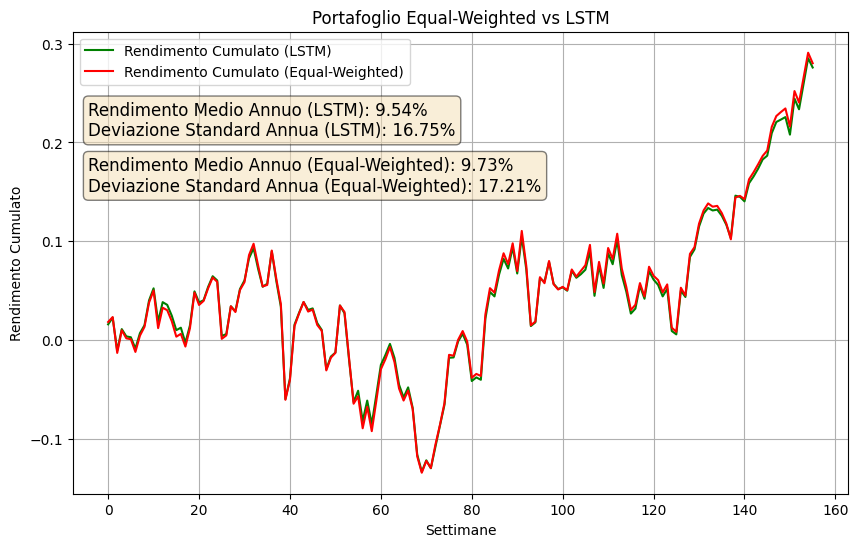

In [69]:
# Importo le funzioni che calcolano le performance di un portafoglio
from portfolio_performance_functions import get_weekly_returns, calculate_portfolio_performance, compare_portfolio_performance

weekly_returns= get_weekly_returns(pd.read_csv("stocks_data_adj_close.csv"))
compare_portfolio_performance(weekly_returns[int(len(weekly_returns) * 0.7):], best_y_pred,  pd.read_csv("df_equally_weighted_portfolio_weights.csv").to_numpy()[int(len(weekly_returns) * 0.7):], plot_title="Portafoglio Equal-Weighted vs LSTM", savefig_name="lstm_results.png", nome_p1= "Equal-Weighted", nome_p2= "LSTM")